In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sympy as sm
import copy
from sympy.abc import *
sm.init_printing()
import fftrefm
reload(fftrefm)
from fftrefm import DDHOZ, DDHOZi, vary_dict, LDS
from scipy import integrate, signal
from scipy.optimize import curve_fit
import tqdm
import sigutils
from kpfm.util import align_labels

In [2]:
def lighter(hex_color, chg):
    rgb = mpl.colors.hex2color(hex_color)
    rgb_out = tuple(min(max(x + chg, 0), 1) for x in rgb)
    return mpl.colors.rgb2hex(rgb_out)

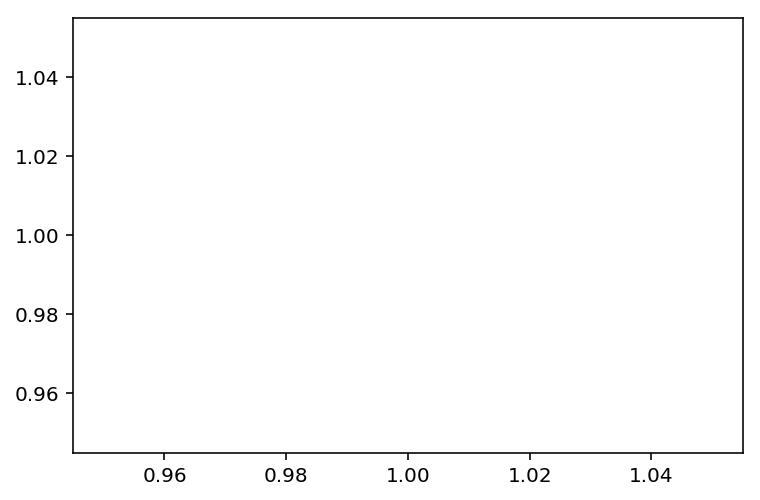

In [3]:
colors = [plt.plot(1, 1)[0].get_color() for i in xrange(4)]

In [4]:
params_full = dict(omega_0=2*np.pi*0.065,
             k=3.5,
             Q=26000.0,
             C=1e-3,
             C2q=0.65e-4,
             C2D=0.65e-4,
             Rs=200,
             Cs=1e-3,
             Vt=lambda t: 0)

T0 = (1/params_full['omega_0']) / (2*np.pi)
dt = T0/4
T = 20000
N = int(T/dt)
t = np.arange(N) * dt

params_full['Ci'] = 0.001
params_full['Ri'] = 200000

sim_params=dict(A=0.05, t=t)

ddhozi = DDHOZi(**params_full)

# # y0zi = np.array([0.00, 0, -1e-3*5, ])

In [5]:
Ris = np.logspace(3, 6, 4)
bas = [fftrefm.tf2rc(**params) for params in vary_dict(params_full, 'Ri', Ris)]

In [6]:
zs = np.array([np.polyval(ba[0], (2*np.pi*0.065j)) / np.polyval(ba[1], (2*np.pi*0.065j)) for ba in bas])

In [7]:
params_full['omega_0']/(2*np.pi) * 1e6 / (4*params_full['k']) * (params_full['C2q'] + params_full['C2D']*zs.real)

array([0.53355869, 0.50260429, 0.50274535, 0.50281866])

In [8]:
params_dicts = list(vary_dict(params_full, 'Ri', Ris))

In [9]:
fc = params_full['omega_0']/(2*np.pi)

In [10]:
import json_tricks

d = json_tricks.load('../results/Fig13-lds-simulation.json')

In [11]:
globals().update(d)

In [12]:
def lds_value(ba, fc, fm, C2q, C2D, Vm=1, k0=3.5):
    H = lambda f: np.polyval(ba[0], 2j*np.pi*f) / np.polyval(ba[1], 2j*np.pi*f)

    Hbar = (H(fm + fc) + H(fm-fc))/2
    return -fc * Vm**2 / (8 * k0) * (C2q + C2D * Hbar) * H(fm)**2 * 1e6 # MHz to Hz

In [13]:
print(d['readme'])


Readme
This file contains data for plots showing the results of simulating
the local dielectric spectroscopy experiment.

The lds simulations were performed using the command:

    lds_s = [LDS(3e-5, 1e-2, 50, 5, params, sim_params)
             for params in tqdm.tqdm(list(vary_dict(params_full, 'Ri', Ris)))]

The modulation voltage was 5 volts (4th argument of LDS command).




In [14]:
dparams = d['params_full'] # ease of typing
dparams

OrderedDict([(u'C', 0.001),
 (u'C2q', 6.5e-05),
 (u'Rs', 200),
 (u'k', 3.5),
 (u'omega_0', 0.4084070449666731),
 (u'Ci', 0.001),
 (u'Q', 26000.0),
 (u'C2D', 6.5e-05),
 (u'Cs', 0.001),
 (u'Ri', 200000)])

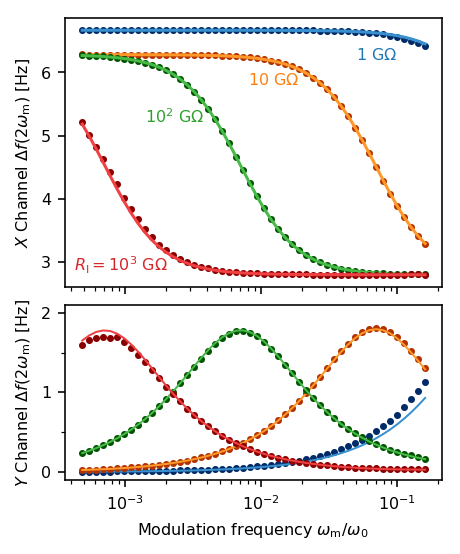

In [15]:
fc = 0.062
plt.rc('font', size=8)
fig, axes = plt.subplots(nrows=2, figsize=(3.38, 2.5*1.7), sharex=True,
                       gridspec_kw=dict(height_ratios=(1, 0.65), hspace=0.08), )

ax = axes

for i, (freq,  z, sim_freq, Ri, ba) in enumerate(zip(d['freqs'], d['zs'], sim_freqs, d['Ris'], bas)):
    if Ri > 100:
        line, = ax[0].semilogx(freq/fc, z.real, '.', label=u"$10^{}$ GΩ".format(
            int(np.round(np.log10(Ri)))-3), markersize=5, color = lighter(colors[i], -0.3))
        ax[0].semilogx(freq/fc, -lds_value(ba, dparams['omega_0']/(2*np.pi),
                                         freq, dparams['C2q'], dparams['C2D'],
                                         Vm=5, k0=dparams['k']).real,
                        color=lighter(colors[i], 0.1), linestyle='-')
#         ax[1].semilogx(freq*1e6, (z.real + lds_value(ba, dparams['omega_0']/(2*np.pi),
#                                          freq, dparams['C2q'], dparams['C2D'],
#                                          Vm=5, k0=dparams['k']).real), '.',
#                        label=u"$10^{}$ GΩ".format(
#                                 int(np.round(np.log10(Ri)))-3),)






        
# plt.legend(loc='upper right')
# ax[1].set_xlabel("Modulation frequency $f_\\mathrm{m}$ [Hz]")
ax[0].set_ylabel("$X$ Channel $\\Delta f(2\\omega_\\mathrm{m})$ [Hz]")
# ax[1].set_ylabel("$r$ [Hz]")
# ax[1].set_ylim([-0.12, 0.12])

# ax = [axes[0][1], axes[1][1]]

for i, (freq,  z, sim_freq, Ri, ba) in enumerate(zip(d['freqs'], d['zs'], sim_freqs, d['Ris'], bas)):
    if Ri > 100:
        line, = ax[1].semilogx(freq/fc, z.imag, '.', label=u"$10^{}$ GΩ".format(
            int(np.round(np.log10(Ri)))-3), markersize=5, color = lighter(colors[i], -0.3))
        ax[1].semilogx(freq/fc, lds_value(ba, dparams['omega_0']/(2*np.pi),
                                         freq, dparams['C2q'], dparams['C2D'],
                                         Vm=5, k0=dparams['k']).imag,
                        color=lighter(colors[i], 0.1), linestyle='-', linewidth=1)
        
#         ax[1].semilogx(freq*1e6, (z.imag - lds_value(ba, dparams['omega_0']/(2*np.pi),
#                                          freq, dparams['C2q'], dparams['C2D'],
#                                          Vm=5, k0=dparams['k']).imag), '.', label=u"$10^{}$ GΩ".format(
#             int(np.round(np.log10(Ri)))-3),)
    


    
ax[0].text(0.05, 6.2, u"$1$ GΩ", color=colors[0])
ax[0].text(0.008, 5.8, u"$10$ GΩ", color=colors[1])
ax[0].text(0.0014, 5.2, u"$10^2$ GΩ", color=colors[2])
ax[0].text(0.00042, 2.85, u"$R_{\\mathrm{I}} = 10^3$ GΩ", color=colors[3])
        
# plt.legend(loc='upper right')
ax[1].set_xlabel("Modulation frequency $\\omega_\\mathrm{m}/\\omega_0$ ")
ax[1].set_ylabel("$Y$ Channel $\\Delta f(2\\omega_\\mathrm{m})$ [Hz]")
# ax[1].set_ylabel("$r$ [Hz]")
# ax[1].set_ylim([-0.25, 0.25])
ax[1].set_ylim(-0.1, 2.1)
ax[1].set_yticks([0, 1, 2])
ax[1].set_yticks([0.5, 1.5], minor=True)

In [16]:
fig.savefig('../figs/Fig13-LDS.pdf', bbox_inches='tight' )